In [79]:
from langchain_dartmouth.llms import ChatDartmouthCloud
from langchain_core.messages import HumanMessage

In [ ]:
!pip install langchain_dartmouth

#### Getting your keys

For your cloud keys:
* Navigate to https://chat.dartmouth.edu/
* Top right corner, then settings
* Account --> API Keys

For guides on models and how to use:
* Guide for Dartmouth LLMs: https://dartmouth.github.io/langchain-dartmouth-cookbook/03-llms.html#third-party-chat-models

In [59]:
key = "sk-XXX" # your key
llm = ChatDartmouthCloud(model_name="openai.gpt-4.1-mini-2025-04-14", dartmouth_chat_api_key=key)

### Text labeling

In [5]:
# Sample Data for Text and Image Labeling
text_data = [
    "The big dog is playing in the park.",
    "My chef is making instant pork ramen for me in the kitchen.",
    "The frat brothers are in the animal house.",
]

In [80]:
prompt = """
Please identify if there are animals in the sentence. 
Respond with 'True' or 'False', with no extra information.
Text: 
"""


In [85]:
text_data[2]

'The frat brothers are in the animal house.'

In [86]:
llm.invoke( prompt + text_data[2] ).content

'False'

In [63]:
prompt + text_data[1]

"\nPlease identify if there are animals in the sentence. \nRespond with 'True' or 'False', with no extra information.\nText: \nMy chef is making instant pork ramen for me in the kitchen."

### Images

In [70]:
import pandas as pd
from PIL import Image
from io import BytesIO
import base64
import glob
import json

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [11]:
url = "https://upload.wikimedia.org/wikipedia/commons/d/d7/Keggywinter2009.jpg"

In [71]:
response = llm.invoke([
    HumanMessage(content=[
        {"type": "text", "text": "Describe what's happening in this image."},
        {"type": "image_url", "image_url": {"url": url}}
    ])
])

print(response.content)

In the image, a person is wearing a large, cylindrical costume that resembles a metal canister or tank with a happy face, including large eyes and a wide smile. The costume has green arms and legs, with the legs covered in green tights and the person wearing white shorts and orange sneakers. The person is standing on a wet sidewalk with patches of snow nearby, and there is a vehicle parked in the background. The overall scene appears to be outdoors in a cold environment, given the presence of snow.


### Old version that works through base64 encoding

In [16]:
# # Downsample and encode
# def encode_image_base64(img):
#     with open(img, "rb") as image_file:
#         return base64.b64encode(image_file.read()).decode('utf-8')
        
# # Function to read, resize, and encode an image in base64
# def process_image(image_path, new_size=(128, 128)):
#     with Image.open(image_path) as img:
#         img = img.resize(new_size)
#         buffered = BytesIO()
#         img.save(buffered, format="JPEG") 
#         img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
#     return img_base64

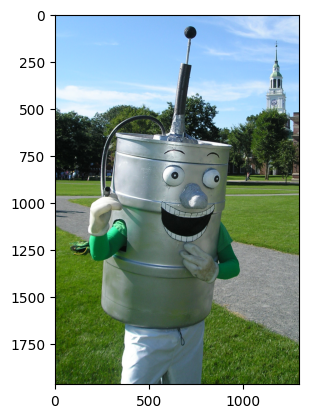

In [20]:
# img     = "Class/QSS45/data/Keggy_the_Keg.jpeg"
# encoded = []
# for f in glob.glob("Class/QSS45/data/*.jpg"):
#     encoded.append(process_image(f))

# img_jpg = mpimg.imread(img)
# plt.imshow(img_jpg)

### Neat JSON Output

In [72]:
label_system_prompt = '''
As a political researcher analyzing U.S. elections, your goal is to evaluate the political standpoint expressed in a provided post. 
Each indicator should represent whether the post supports or opposes various political figures or parties.
Based on the post's content, you will need to output a JSON object containing various binary indicators (0 or 1) reflecting specific conditions: 

{
    pro_democrat: int, // Set to 1 if the post supports the Democratic party, otherwise 0,
    against_democrat: int, // Set to 1 if the post opposes the Democratic party, otherwise 0,
    pro_republican: int, // Set to 1 if the post supports the Republican party, otherwise 0,
    against_republican: int, // Set to 1 if the post opposes the Republican party, otherwise 0,
    pro_biden: int, // Set to 1 if the post supports Joe Biden, otherwise 0,
    against_biden: int, // Set to 1 if the post opposes Joe Biden, otherwise 0,
    pro_trump: int, // Set to 1 if the post supports Donald Trump, otherwise 0,
    against_trump: int, // Set to 1 if the post opposes Donald Trump, otherwise 0,
    pro_kamala: int, // Set to 1 if the post supports Kamala Harris, otherwise 0,
    against_kamala: int // Set to 1 if the post opposes Kamala Harris, otherwise 0
}
'''

In [46]:
text_data = [
    "The big dog is playing in the park.",
    "My chef is making instant pork ramen for me in the kitchen.",
    "The frat brothers are in the animal house.",
    "Kamala Harris is great and in a two-way horse race.",
    "Trump is lovely and said immigrants eat pets."
]

In [73]:
def label_text_json(t):
    return llm.invoke( label_system_prompt + t )

In [74]:
text_data[3]

'Kamala Harris is great and in a two-way horse race.'

In [77]:
label = label_text_json(text_data[3])

In [78]:
label.content

'{\n  "pro_democrat": 1,\n  "against_democrat": 0,\n  "pro_republican": 0,\n  "against_republican": 0,\n  "pro_biden": 0,\n  "against_biden": 0,\n  "pro_trump": 0,\n  "against_trump": 0,\n  "pro_kamala": 1,\n  "against_kamala": 0\n}'

In [51]:
import json
import pandas as pd

In [52]:
b = json.loads(label.content)

In [53]:
b

{'pro_democrat': 1,
 'against_democrat': 0,
 'pro_republican': 0,
 'against_republican': 0,
 'pro_biden': 0,
 'against_biden': 0,
 'pro_trump': 0,
 'against_trump': 0,
 'pro_kamala': 1,
 'against_kamala': 0}

In [54]:
fake_data = [b]*4
df = pd.DataFrame(fake_data)
df

,pro_democrat,against_democrat,pro_republican,against_republican,pro_biden,against_biden,pro_trump,against_trump,pro_kamala,against_kamala
0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0


# Ranking task | Silicon Sampling

In [ ]:
text = """
        Based on general importance, rank the following topics by importance before viewing any specific content:
        Topics: {}
        Output JSON only in the following format:
        {{
            "prior_abortion": int,
            "prior_econ": int,
            "prior_gaza": int,
            "prior_harris": int,
            "prior_trump": int,
            "prior_dress": int,
            "prior_dogs": int
        }}
        """
prompt_word_count = len(text.split())

topics = ["abortion", "econ", "harris", "trump", "pets"]
iterations = 10

df = pd.DataFrame()

df["topic_order"] = [random.sample(topics, len(topics)) for i in range(iterations)]
df["text"] = df.topic_order.apply(lambda x: text.format(', '.join(x)))

In [ ]:
# For one task
llm.invoke(df.text.values[0])